In [5]:
from brian2 import *
from scipy.stats import pearsonr
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

# Main Params
N_I = 1000
N_E = 3000
N_IA = 150

p_con_n = 0.2 # Probability of connection, for basic network (II, IE, EI)
p_con_a = 0.2 # Probability of connection, for attractor network (IxyE)
drive_I = 20000 # Total drive for inhibitory population
drive_E = 24000 # Total drive for excitatory population
# drive_IA = 1500 # Total drive for attractive inhibitory population

# voltage
V_L = -70. * mV # Resting potential
V_thr = -52. * mV  # Threshold for firing
V_reset = -59. * mV  # Resest voltage
V_E = 0 * mV  # Reversal potential excitatory
V_I = -70. * mV  # Reversal potential inhibitory

# refractory period
ref_E = 2. * ms
ref_I = 1. * ms

# external stimuli 
C_ext = 800  # Number of inputs

# Total input for inhibitory population
total_input_I = int(drive_I / C_ext)
rate_I = total_input_I * Hz

# Total input for excitatory population
total_input_E = int(drive_E / C_ext)
rate_E = total_input_E * Hz

# Membrane time constants for I and E
tau_m_I = 10 * ms
tau_m_E = 20 * ms

# Conductances for interneurons
g_GABA_I = 4 * nS
g_AMPA_Ia = 0.2 * nS
g_AMPA_I = 0.2 * nS 
g_NMDA_I = 0.1 * nS
g_AMPA_ext_I = 0.3 * nS

# Conductances for excitatory
g_GABA_E = 2.5 * nS
g_AMPA_E = 0.19 * nS
g_NMDA_E = 0.06 * nS
g_AMPA_ext_E = 0.3 * nS

# Time constants for GABA
tau_d_GABA = 5 * ms
tau_r_GABA = 0.5 * ms
tau_l_GABA = 0.5 * ms
tau_l_GABA_a = 1 *ms

# Time constants for poisson inputs
tau_d_Ext = 2 * ms
tau_r_Ext = 0.5 * ms
tau_l_Ext = 1 * ms

# Time constants for AMPA
tau_d_AMPA = 2 * ms
tau_r_AMPA = 0.4 * ms
tau_l_AMPA = 1 * ms

# Conductance and Membrane Leak (for correct units)
c_m_I = 0.2 * nF #0.2 * nF
g_m_I = 20 * nS #20. * nS
c_m_E = 0.5 * nF #0.5 * nF
g_m_E = 25 * nS #25. * nS

eqs_I = '''
dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt (unless refractory)

I_syn = I_Ext + I_AMPA + I_GABA: amp 

I_GABA =  g_GABA_I * (v - V_I) * s_GABA : amp
I_AMPA =  g_AMPA_I * (v - V_E) * s_AMPA : amp
I_Ext =  g_AMPA_ext_I * (v - V_E) * s_Ext : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
dc_g/dt = -c_g/tau_r_GABA : 1

ds_AMPA/dt = ((tau_r_AMPA / tau_d_AMPA) ** \
             (tau_d_AMPA / (tau_r_AMPA - tau_d_AMPA))*c_a-s_AMPA)/tau_d_AMPA : 1
dc_a/dt = -c_a/tau_r_AMPA : 1

ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
             (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p_I-s_Ext)/tau_d_Ext : 1
dc_p_I/dt = -c_p_I/tau_r_Ext : 1
'''

eqs_E = '''
dv/dt = (-g_m_E * (v - V_L) - I_syn) / c_m_E : volt (unless refractory)

I_syn = I_Ext + I_AMPA + I_GABA: amp 

I_GABA =  g_GABA_E * (v - V_I) * s_GABA : amp
I_AMPA =  g_AMPA_E * (v - V_E) * s_AMPA : amp
I_Ext =  g_AMPA_ext_E * (v - V_E) * s_Ext : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
dc_g/dt = -c_g/tau_r_GABA : 1

ds_AMPA/dt = ((tau_r_AMPA / tau_d_AMPA) ** \
             (tau_d_AMPA / (tau_r_AMPA - tau_d_AMPA))*c_a-s_AMPA)/tau_d_AMPA : 1
dc_a/dt = -c_a/tau_r_AMPA : 1

ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
             (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p_E-s_Ext)/tau_d_Ext : 1
dc_p_E/dt = -c_p_E/tau_r_Ext : 1
'''

eqs_IA = '''
dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt (unless refractory)

I_syn = I_Ext + I_AMPA + I_GABA: amp 

I_GABA =  g_GABA_I * (v - V_I) * s_GABA : amp
I_AMPA =  g_AMPA_Ia * (v - V_E) * s_AMPA : amp
I_Ext =  g_AMPA_ext_I * (v - V_E) * s_Ext : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
dc_g/dt = -c_g/tau_r_GABA : 1

ds_AMPA/dt = ((tau_r_AMPA / tau_d_AMPA) ** \
             (tau_d_AMPA / (tau_r_AMPA - tau_d_AMPA))*c_a-s_AMPA)/tau_d_AMPA : 1
dc_a/dt = -c_a/tau_r_AMPA : 1

ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
             (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p_I-s_Ext)/tau_d_Ext : 1
dc_p_I/dt = -c_p_I/tau_r_Ext : 1
'''

# Build Neuron groups
# I is main inhibitory, PEn are the excitatory populations, P_Ixy are inhibitory loops from x to y
P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_E1 = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=ref_E, method='euler')
P_E2 = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=ref_E, method='euler')
P_E3 = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=ref_E, method='euler')
P_I12 = NeuronGroup(N_IA, eqs_IA, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_I21 = NeuronGroup(N_IA, eqs_IA, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_I13 = NeuronGroup(N_IA, eqs_IA, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_I31 = NeuronGroup(N_IA, eqs_IA, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_I23 = NeuronGroup(N_IA, eqs_IA, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_I32 = NeuronGroup(N_IA, eqs_IA, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')

# Set initial values
P_I.v = V_L
P_E1.v = V_L
P_E2.v = V_L
P_E3.v = V_L
P_I12.v = V_L
P_I21.v = V_L
P_I13.v = V_L
P_I31.v = V_L
P_I23.v = V_L
P_I32.v = V_L

# Add poisson, AMPA-like drive to 'main' parts of my population
P_D_I = PoissonInput(P_I, 'c_p_I', C_ext, rate_I, '1')
P_D_E1 = PoissonInput(P_E1, 'c_p_E', C_ext, rate_E, '1')
P_D_E2 = PoissonInput(P_E2, 'c_p_E', C_ext, rate_E, '1')
P_D_E3 = PoissonInput(P_E3, 'c_p_E', C_ext, rate_E, '1')

# Synaptic equations
pre_GABA = '''
c_g += 1
'''

pre_AMPA = '''
c_a += 1
'''

# Build your 'main' inhibitory synapses
C_I_I = Synapses(P_I, P_I, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_E1 = Synapses(P_I, P_E1, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_E2 = Synapses(P_I, P_E2, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_E3 = Synapses(P_I, P_E3, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)

C_I_I.connect(condition='i != j', p=p_con_n)
C_I_E1.connect(p=p_con_n)
C_I_E2.connect(p=p_con_n)
C_I_E3.connect(p=p_con_n)

# Build your 'main' excitatory synapses
C_E1_I = Synapses(P_E1, P_I, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E2_I = Synapses(P_E2, P_I, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E3_I = Synapses(P_E3, P_I, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)

C_E1_I.connect(p=p_con_n)
C_E2_I.connect(p=p_con_n)
C_E3_I.connect(p=p_con_n)

# Build your 'attractor' synapses, E to I
C_E1_I12 = Synapses(P_E1, P_I12, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E1_I13 = Synapses(P_E1, P_I13, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E2_I21 = Synapses(P_E2, P_I21, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E2_I23 = Synapses(P_E2, P_I23, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E3_I31 = Synapses(P_E3, P_I31, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)
C_E3_I32 = Synapses(P_E3, P_I32, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)

C_E1_I12.connect(p=p_con_a)
C_E1_I13.connect(p=p_con_a)
C_E2_I21.connect(p=p_con_a)
C_E2_I23.connect(p=p_con_a)
C_E3_I31.connect(p=p_con_a)
C_E3_I32.connect(p=p_con_a)

# Build your 'attractor' synapses, I to E
C_I12_E2 = Synapses(P_I12, P_E2, on_pre=pre_GABA, method='euler', delay=tau_l_GABA_a)
C_I21_E1 = Synapses(P_I21, P_E1, on_pre=pre_GABA, method='euler', delay=tau_l_GABA_a)
C_I13_E3 = Synapses(P_I13, P_E3, on_pre=pre_GABA, method='euler', delay=tau_l_GABA_a)
C_I31_E1 = Synapses(P_I31, P_E1, on_pre=pre_GABA, method='euler', delay=tau_l_GABA_a)
C_I23_E3 = Synapses(P_I23, P_E3, on_pre=pre_GABA, method='euler', delay=tau_l_GABA_a)
C_I32_E2 = Synapses(P_I32, P_E2, on_pre=pre_GABA, method='euler', delay=tau_l_GABA_a)

C_I12_E2.connect(p=p_con_a)
C_I21_E1.connect(p=p_con_a)
C_I13_E3.connect(p=p_con_a)
C_I31_E1.connect(p=p_con_a)
C_I23_E3.connect(p=p_con_a)
C_I32_E2.connect(p=p_con_a)

s_I = SpikeMonitor(P_I[:20])
s_E1 = SpikeMonitor(P_E1[:20])
s_E2 = SpikeMonitor(P_E2[:20])
s_E3 = SpikeMonitor(P_E3[:20])
s_I12 = SpikeMonitor(P_I12[:20])
s_I21 = SpikeMonitor(P_I21[:20])
s_I13 = SpikeMonitor(P_I13[:20])
s_I31 = SpikeMonitor(P_I31[:20])
s_I23 = SpikeMonitor(P_I23[:20])
s_I32 = SpikeMonitor(P_I32[:20])

p_I = PopulationRateMonitor(P_I)
p_E1 = PopulationRateMonitor(P_E1)
p_E2 = PopulationRateMonitor(P_E2)
p_E3 = PopulationRateMonitor(P_E3)
p_I12 = PopulationRateMonitor(P_I12)

M = StateMonitor(P_I12, ('I_AMPA', 'v', 's_AMPA', 'I_Ext'), record=True)

net = Network(P_I, P_E1, P_E2, P_E3, P_I12, P_I21, P_I13, P_I31, P_I23, P_I32, \
              C_I_I, C_I_E1, C_I_E2, C_I_E3, C_E1_I, C_E2_I, C_E3_I, \
              C_E1_I12, C_E1_I13, C_E2_I21, C_E2_I23, C_E3_I31, C_E3_I32, \
              C_I12_E2, C_I21_E1, C_I13_E3, C_I31_E1, C_I23_E3, C_I32_E2, \
              P_D_I, P_D_E1, P_D_E2, P_D_E3, \
              s_I, s_E1, s_E2, s_E3, s_I12, s_I21, s_I13, s_I31, s_I23, s_I32,  \
              p_I, p_E1, p_E2, p_E3, p_I12, M)

test_drive = [0]
output = []

net.store()
for test_rate in test_drive:
    net.restore()

    # Total input for attractive inhibitory population
    drive_IA = test_rate
    total_input_IA = round(drive_IA / C_ext , 3)
    rate_IA = total_input_IA * Hz
    
    # Define the attractor inputs with new rates
    P_D_I12 = PoissonInput(P_I12, 'c_p_I', C_ext, rate_IA, '1')
    P_D_I21 = PoissonInput(P_I21, 'c_p_I', C_ext, rate_IA, '1')
    P_D_I13 = PoissonInput(P_I13, 'c_p_I', C_ext, rate_IA, '1')
    P_D_I31 = PoissonInput(P_I31, 'c_p_I', C_ext, rate_IA, '1')
    P_D_I23 = PoissonInput(P_I23, 'c_p_I', C_ext, rate_IA, '1')
    P_D_I32 = PoissonInput(P_I32, 'c_p_I', C_ext, rate_IA, '1')
    
    # Add them to the network
    net.add(P_D_I12, P_D_I21, P_D_I13, P_D_I31, P_D_I23, P_D_I32)
    
    # Run
    net.run(2.5 * second)

    # Save output
    output.append((s_I, s_E1, s_E2, s_E3, s_I12, s_I21, s_I13, s_I31, s_I23, s_I32, p_I, p_E1, p_E2, p_E3, p_I12))
    
    # Remove the drives to 'clear' them
    net.remove(P_D_I12, P_D_I21, P_D_I13, P_D_I31, P_D_I23, P_D_I32)
    print('Drives: ' + str(drive_IA) +' Hz')
print('Done')

Drives: 0 Hz
Done


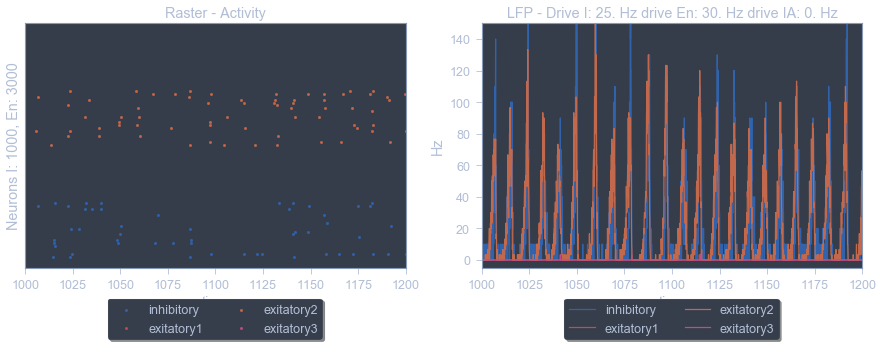

In [6]:
s_I, s_E1, s_E2, s_E3, s_I12, s_I21, s_I13, s_I31, s_I23, s_I32, p_I, p_E1, p_E2, p_E3, p_I12 = output[0]

inhib_c = '#3063ab'
exct1_c = '#c24c4e' 
exct2_c = '#c2684c' 
exct3_c = '#c24c89' 
face = '#363d4a'

figure(figsize=(15, 5))
subplot(121)
plt.scatter(s_I.t / ms, s_I.i, color= inhib_c, marker ='.', label='inhibitory')
plt.scatter(s_E1.t / ms, (s_E1.i + 20), color= exct1_c, marker ='.', label='exitatory1')
plt.scatter(s_E2.t / ms, (s_E2.i + 40), color= exct2_c, marker ='.', label='exitatory2')
plt.scatter(s_E3.t / ms, (s_E3.i + 60), color= exct3_c, marker ='.', label='exitatory3')
yticks([])
title('Raster - Activity')
xlabel('ms')
xlabel('time')
ylabel('Neurons I: ' + str(N_I) + ', En: ' + str(N_E))
ax = plt.gca()
box = ax.get_position()
ax.set_facecolor(face)
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
xlim([1000, 1200])

subplot(122)
# plot_max = np.max(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
plt.plot(p_I.t / ms, p_I.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= inhib_c, label='inhibitory')
plt.plot(p_E1.t / ms, p_E1.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= exct1_c, label='exitatory1')
plt.plot(p_E2.t / ms, p_E2.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= exct2_c, label='exitatory2')
plt.plot(p_E3.t / ms, p_E3.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= exct3_c, label='exitatory3')
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
title('LFP - Drive I: ' + str(rate_I) + ' drive En: ' + str(rate_E) + ' drive IA: ' + str(rate_IA) )
xlabel('ms')
xlabel('time')
ylabel('Hz')
# ylim((-5 , plot_max + (0.2*plot_max)))
xlim([1000, 1200])
ylim([-5, 150])
ax = plt.gca()
ax.set_facecolor(face)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])


# plt.text(1025, plot_max + (0.025*plot_max), 'g_ext_I: ' + str(g_AMPA_ext_I / nS) + 'nS' , fontsize=16)
# plt.text(1025,  plot_max - (0.1*plot_max) , 'g_ext_E: ' + str(g_AMPA_ext_E / nS) + 'nS' , fontsize=16)



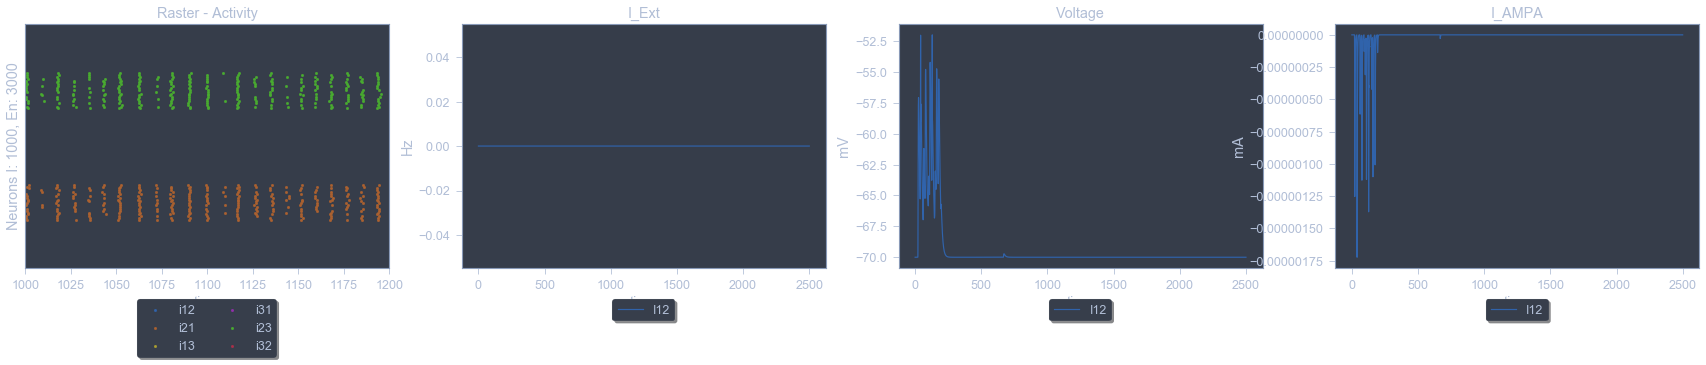

In [7]:
inhib1_c = '#3063ab'
inhib2_c = '#ab6130' 
inhib3_c = '#ab9f30' 
inhib4_c = '#9230ab' 
inhib5_c = '#49ab30' 
inhib6_c = '#ab3049' 
face = '#363d4a'

figure(figsize=(30, 5))
subplot(141)
plt.scatter(s_I12.t / ms, s_I12.i + 0, color= inhib1_c, marker ='.', label='i12')
plt.scatter(s_I21.t / ms, s_I21.i + 20, color= inhib2_c, marker ='.', label='i21')
plt.scatter(s_I13.t / ms, s_I13.i + 40, color= inhib3_c, marker ='.', label='i13')
plt.scatter(s_I31.t / ms, s_I31.i + 60, color= inhib4_c, marker ='.', label='i31')
plt.scatter(s_I23.t / ms, s_I23.i + 80, color= inhib5_c, marker ='.', label='i23')
plt.scatter(s_I32.t / ms, s_I32.i + 100, color= inhib6_c, marker ='.', label='i32')

yticks([])
title('Raster - Activity')
xlabel('ms')
xlabel('time')
ylabel('Neurons I: ' + str(N_I) + ', En: ' + str(N_E))
ax = plt.gca()
box = ax.get_position()
ax.set_facecolor(face)
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
xlim([1000, 1200])

subplot(142)
# plot_max = np.max(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
plot(M.t/ms, M.I_Ext[0], color= inhib1_c, label='I12')

title('I_Ext')
#plt.plot(p_I12.t / ms, p_I12.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= inhib1_c, label='I12')
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
#title('LFP - Drive I: ' + str(rate_I) + ' drive En: ' + str(rate_E) + ' drive IA: ' + str(rate_IA) )
xlabel('ms')
xlabel('time')
ylabel('Hz')
# ylim((-5 , plot_max + (0.2*plot_max)))
# xlim([1000, 1200])
# ylim([-5, 150])
ax = plt.gca()
ax.set_facecolor(face)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

subplot(143)
# plot_max = np.max(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
plt.plot(M.t / ms, M.v[0] / mV, color= inhib1_c, label='I12')
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
title('Voltage')
xlabel('ms')
xlabel('time')
ylabel('mV')
# ylim((-5 , plot_max + (0.2*plot_max)))
ax = plt.gca()
ax.set_facecolor(face)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

subplot(144)
# plot_max = np.max(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
plt.plot(M.t / ms, M.I_AMPA[0] / mA, color= inhib1_c, label='I12')
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
title('I_AMPA')
xlabel('ms')
xlabel('time')
ylabel('mA')
# ylim((-5 , plot_max + (0.2*plot_max)))
ax = plt.gca()
ax.set_facecolor(face)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

